In [ ]:
import os, math, random, copy
#import requests as req
#from google.colab import drive
from typing import Sequence, Union
import gdown, zipfile
from abc import abstractmethod
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from torch import nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

#drive.mount('/content/drive')
#torch.backends.cudnn.enabled = False
random.seed(42)
np.random.seed(42)
th.manual_seed(42)

In [ ]:
#@title
class UserPhotos:
    def __init__(self, username = ""):
        user_photos_folder = "/content/drive/My Drive/" + username
        if not os.path.isdir(user_photos_folder):
            os.mkdir(user_photos_folder)
            headers = {
                'x-rapidapi-host': "api.rapidapi.com",
                'x-rapidapi-key': "KEY"
            }
            res = req.get("https://api.rapidapi.com/account-info", headers = headers, params = {"username": username})
            user_id = res.json()['id']
            res = req.get("https://api.rapidapi.com/account-medias", headers = headers, params = {"userid": user_id, "first": "50"})
            photos = res.json()["edges"]
            for photo in photos:
                photo_url = photo["node"]["display_resources"][0]["src"]
                downloaded_photo = req.get(photo_url)
                if downloaded_photo.status_code == 200:
                    with open(user_photos_folder + '/' + str(photos.index(photo)) + ".jpg", 'wb') as f:
                        f.write(downloaded_photo.content)

UserPhotos("pokimanelol")

In [ ]:
#@title CelebA Dataset
class CelebA(Dataset):
    def __init__(self, train = True, subsample = None, norm = True):
        self.path = "/content/datasets/"
        url = "https://drive.google.com/uc?id=1R5EmVSSySBkTQwpTX3MRaAvC5cxlO-Aj"
        self.imgs = []
        self.norm = norm
        self.trans = T.Compose([T.Resize((64, 64)), T.RandomHorizontalFlip()])
        if not os.path.exists(self.path):
            os.makedirs(self.path)
            gdown.download(url, "/content/img_align_celeba.zip")
            with zipfile.ZipFile("/content/img_align_celeba.zip", 'r') as zip:
                zip.extractall(self.path)
        
        for img in os.listdir(self.path + "img_align_celeba/"):
            self.imgs.append(os.path.join(self.path + "img_align_celeba/", img))
        
        if subsample is not None:
            self.imgs = self.imgs[:subsample]
            #self.images = np.random.choice(self.images, size = subsample, replace = False)
        

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        #img = th.from_numpy(np.load(self.imgs[idx])).permute(2, 0, 1)
        if self.trans is not None:
            img = self.trans(img)
        
        if self.norm:
            img = (np.asarray(img).astype(np.float) / 127.5) - 1.0
            # Normalize between (-1, 1) (Assuming between [0, 1])
            #img = 2 * img - 1
        else:
            #pass
            img = np.asarray(img).astype(np.float) / 255.0
        img = th.from_numpy(img).permute(2, 0, 1).float()
        return img#, img

    def __len__(self): 
        return len(self.imgs)


In [ ]:
!rm -rf /content/datasets

In [ ]:
!rm -rf /content/generated/

In [ ]:
BATCH_SIZE = 32 # 64 for sampling maybe
EPOCHS = 15
LR = 2 * 0.0001
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
# NUM_WORKERS = 2

In [ ]:
#@title util.py

def show_image_grid(img_size, nr_imgs):
    path = "/content/generated/"
    imgs = th.zeros([nr_imgs, 3, img_size, img_size])
    for i in range(nr_imgs):
        img = Image.open(path + "img_" + str(i) + ".png")
        imgs[i] = T.ToTensor()(img)
    #_, ax = plt.subplots(1, nr_imgs, figsize=(15, 20))
    plt.figure(figsize = (15, 20))
    plt.axis("off")
    plt.imshow(make_grid(imgs, padding = 2, normalize = True).permute(1, 2, 0))
    #plt.imshow(grid, cmap = 'gray')


def plot_interpolations(interpolations, save_path = None, figsize = (10, 5)):
    N = len(interpolations)
    # Plot all the quantities
    fig, ax = plt.subplots(nrows=1, ncols=N, figsize=figsize)

    for i, inter in enumerate(interpolations):
        ax[i].imshow(inter.squeeze().permute(1, 2, 0))
        ax[i].axis("off")

    if save_path is not None:
        plt.savefig(save_path, dpi=300, pad_inches=0)


def convert_to_np(obj):
    obj = obj.permute(0, 2, 3, 1).contiguous()
    obj = obj.detach().cpu().numpy()

    obj_list = []
    for _, out in enumerate(obj):
        obj_list.append(out)
    return obj_list


def save_as_images(obj, file_name="output", denorm=True):
    # Saves predictions as png images (useful for Sample generation)
    if denorm:
        # obj = normalize(obj)
        obj = obj * 0.5 + 0.5
    obj_list = convert_to_np(obj)

    for i, out in enumerate(obj_list):
        out = (out * 255).clip(0, 255).astype(np.uint8)
        img_out = Image.fromarray(out)
        current_file_name = file_name + "_%d.png" % i
        print("Saving image to {}".format(current_file_name))
        img_out.save(current_file_name, "png")


def save_as_np(obj, file_name="output", denorm=True):
    # Saves predictions directly as numpy arrays
    if denorm:
        obj = normalize(obj)
    obj_list = convert_to_np(obj)

    for i, out in enumerate(obj_list):
        current_file_name = file_name + "_%d.npy" % i
        print("Saving image to {}".format(current_file_name))
        np.save(current_file_name, out)

In [ ]:
#@title unet_openai.py
class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

def conv_nd(dims, *args, **kwargs):
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")

def linear(*args, **kwargs):
    return nn.Linear(*args, **kwargs)

def avg_pool_nd(dims, *args, **kwargs):
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")

def zero_module(module):
    # Zero out the parameters of a module and return it.
    for p in module.parameters():
        p.detach().zero_()
    return module

def normalization(channels):
    """
    Make a standard normalization layer.
    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)

def timestep_embedding(timesteps, dim, max_period = 10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period) * th.arange(start=0, end=half, dtype=th.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.
    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(th.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with th.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with th.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = th.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(dims, channels, channels, 3, stride=stride, padding=1)
        else:
            self.op = avg_pool_nd(stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(self, channels, num_heads=1, use_checkpoint=False):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.use_checkpoint = use_checkpoint

        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        self.attention = QKVAttention()
        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), self.use_checkpoint)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        qkv = qkv.reshape(b * self.num_heads, -1, qkv.shape[2])
        h = self.attention(qkv)
        h = h.reshape(b, -1, h.shape[-1])
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention.
    """

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (C * 3) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x C x T] tensor after attention.
        """
        ch = qkv.shape[1] // 3
        q, k, v = th.split(qkv, ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        return th.einsum("bts,bcs->bct", weight, v)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    """

    def __init__(
        self,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        num_heads=1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.num_heads = num_heads
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch, use_checkpoint=use_checkpoint, num_heads=num_heads
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(
                    TimestepEmbedSequential(Downsample(ch, conv_resample, dims=dims))
                )
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(ch, use_checkpoint=use_checkpoint, num_heads=num_heads),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=model_channels * mult,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                        )
                    )
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample, dims=dims))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),
        )

    @property
    def inner_dtype(self):
        """
        Get the dtype used by the torso of the model.
        """
        return next(self.input_blocks.parameters()).dtype

    def forward(self, x, timesteps, y=None, **kwargs):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.inner_dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            cat_in = th.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        h = h.type(x.dtype)
        return self.out(h)


class SuperResModel(UNetModel):
    """
    A UNetModel that performs super-resolution.
    Expects an extra kwarg `low_res` to condition on a low-resolution image.
    """

    def __init__(self, in_channels, *args, **kwargs):
        super().__init__(in_channels * 2, *args, **kwargs)

    def forward(self, x, timesteps, low_res=None, **kwargs):
        _, _, new_height, new_width = x.shape

        if low_res is not None:
            upsampled = F.interpolate(low_res, (new_height, new_width), mode="nearest")
            x = th.cat([x, upsampled], dim=1)
        return super().forward(x, timesteps, **kwargs)

In [ ]:
#@title ddpm.py

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t).float()
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


class DDPM(nn.Module):
    def __init__(self, decoder, beta_1 = 1e-4, beta_2 = 0.02,
        T = 1000, var_type = "fixedlarge", ddpm_latents = None):
        
        super().__init__()
        self.decoder = decoder
        self.T = T
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.var_type = var_type
        self.ddpm_latents = ddpm_latents

        # Main constants
        self.register_buffer("betas", th.linspace(self.beta_1, self.beta_2, steps = self.T).double())
        dev = self.betas.device
        alphas = 1.0 - self.betas
        alpha_bar = th.cumprod(alphas, dim = 0)
        alpha_bar_shifted = th.cat([th.tensor([1.0], device=dev), alpha_bar[:-1]])

        assert alpha_bar_shifted.shape == th.Size([self.T])

        # Auxillary consts
        self.register_buffer("sqrt_alpha_bar", th.sqrt(alpha_bar))
        self.register_buffer("minus_sqrt_alpha_bar", th.sqrt(1.0 - alpha_bar))
        self.register_buffer("sqrt_recip_alphas_cumprod", th.sqrt(1.0 / alpha_bar))
        self.register_buffer("sqrt_recipm1_alphas_cumprod", th.sqrt(1.0 / alpha_bar - 1))

        # Posterior q(x_t-1|x_t,x_0,t) covariance of the forward process
        self.register_buffer("post_variance", self.betas * (1.0 - alpha_bar_shifted) / (1.0 - alpha_bar))
        # Clipping because post_variance is 0 before the chain starts
        self.register_buffer(
            "post_log_variance_clipped",
            th.log(th.cat([th.tensor([self.post_variance[1]], device = dev), self.post_variance[1:],])),
        )

        # q(x_t-1 | x_t, x_0) mean coefficients
        self.register_buffer("post_coeff_1", self.betas * th.sqrt(alpha_bar_shifted) / (1.0 - alpha_bar),)
        self.register_buffer("post_coeff_2", th.sqrt(alphas) * (1 - alpha_bar_shifted) / (1 - alpha_bar),)

    def _predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def get_posterior_mean_covariance(self, x_t, t, clip_denoised=True, cond=None):
        B = x_t.size(0)
        t_ = th.full((x_t.size(0),), t, device=x_t.device, dtype=th.long)
        assert t_.shape == th.Size([B,])

        # Generate the reconstruction from x_t
        x_recons = self._predict_xstart_from_eps(x_t, t_, self.decoder(x_t, t_, low_res = cond))

        # Clip
        if clip_denoised:
            x_recons.clamp_(-1.0, 1.0)

        # Compute posterior mean from the reconstruction
        post_mean = (
            extract(self.post_coeff_1, t_, x_t.shape) * x_recons
            + extract(self.post_coeff_2, t_, x_t.shape) * x_t
        )

        # Extract posterior variance
        p_variance, p_log_variance = {
            # for fixedlarge, we set the initial (log-)variance like so
            # to get a better decoder log likelihood.
            "fixedlarge": (
                self.betas,
                th.log(th.cat([th.tensor([self.post_variance[1]], device = x_t.device), self.betas[1:],])
                ),
            ),
            "fixedsmall": (self.post_variance, self.post_log_variance_clipped,),
        }[self.var_type]
        post_variance = extract(p_variance, t_, x_t.shape)
        post_log_variance = extract(p_log_variance, t_, x_t.shape)
        return post_mean, post_variance, post_log_variance

    def sample(self, x_t, cond = None, n_steps = None, checkpoints = []):
        # The sampling process goes here!
        x = x_t
        B, *_ = x_t.shape
        sample_dict = {}

        if self.ddpm_latents is not None:
            self.ddpm_latents = self.ddpm_latents.to(x_t.device)

        num_steps = self.T if n_steps is None else n_steps
        checkpoints = [num_steps] if checkpoints == [] else checkpoints
        for idx, t in enumerate(reversed(range(0, num_steps))):
            z = (
                th.randn_like(x_t)
                if self.ddpm_latents is None
                else th.stack([self.ddpm_latents[idx]] * B)
            )
            assert z.shape == x_t.shape
            (
                post_mean,
                post_variance,
                post_log_variance,
            ) = self.get_posterior_mean_covariance(
                x,
                t,
                cond=cond,
            )
            nonzero_mask = (
                th.tensor(t != 0, device=x.device)
                .float()
                .view(-1, *([1] * (len(x_t.shape) - 1)))
            )  # no noise when t == 0

            # Langevin step!
            x = post_mean + nonzero_mask * th.exp(0.5 * post_log_variance) * z

            # Add results
            if idx + 1 in checkpoints:
                sample_dict[str(idx + 1)] = x
        return sample_dict

    def compute_noisy_input(self, x_start, eps, t):
        assert eps.shape == x_start.shape
        # Samples the noisy input x_t ~ q(x_t|x_0) in the forward process
        return x_start * extract(self.sqrt_alpha_bar, t, x_start.shape) + eps * extract(
            self.minus_sqrt_alpha_bar, t, x_start.shape
        )

    def forward(self, x, eps, t, low_res=None):
        # Predict noise
        x_t = self.compute_noisy_input(x, eps, t)
        return self.decoder(x_t, t, low_res=low_res)

In [ ]:
#@title DiffusionVAE
class DiffusionVAE:
    def __init__(self, online_network, target_network, vae = None, lr = 2e-5, n_anneal_steps = 0,
                loss = "l1", grad_clip_val = 1.0, sample_from = "target", conditional = True,
                eval_mode = "sample", pred_steps = None, pred_checkpoints = [], data_norm = True, temp = 1.0):
        
        assert loss in ["l1", "l2"]
        assert eval_mode in ["sample", "recons"]
        
        self.sample_from = sample_from
        self.sample_prefix = ""
        self.conditional = conditional
        self.online_network = online_network.cuda()
        self.target_network = target_network.cuda()
        self.vae = vae

        # Training arguments
        self.criterion = nn.MSELoss(reduction = "mean") if loss == "l2" else nn.L1Loss()
        self.lr = lr
        self.grad_clip_val = grad_clip_val
        self.n_anneal_steps = n_anneal_steps
        self.optim = th.optim.Adam(self.online_network.decoder.parameters(), lr = self.lr)
        self.lr_sched = self.get_scheduler()
        self.tau = 0.9999

        # Evaluation arguments
        self.eval_mode = eval_mode
        self.pred_steps = self.online_network.T if pred_steps is None else pred_steps
        self.pred_checkpoints = pred_checkpoints
        self.data_norm = data_norm
        self.temp = temp

        # Disable automatic optimization
        self.automatic_optimization = False

    def get_scheduler(self):
        # Define the LR scheduler (As in Ho et al.)
        if self.n_anneal_steps == 0:
            lr_lambda = lambda step: 1.0
        else:
            lr_lambda = lambda step: min(step / self.n_anneal_steps, 1.0)
        scheduler = th.optim.lr_scheduler.LambdaLR(self.optim, lr_lambda)
        return scheduler

    def train(self, train_loader, ema = False):
        total_loss = 0.0
        for e in range(EPOCHS):
            last_total_loss = total_loss
            total_loss = 0.0
            for i, batch in enumerate(train_loader):
                cond = None
                if self.conditional:
                    cond, x = batch
                    cond = cond.cuda()
                    x = x.cuda()
                else:
                    x = batch
                    x = x.cuda()
                
                # Sample timepoints
                t = th.randint(0, self.online_network.T, size=(x.size(0),)).cuda()

                # Sample noise
                eps = th.randn_like(x).cuda()

                # Predict noise
                eps_pred = self.online_network(x, eps, t, low_res = cond)

                # Compute loss
                loss = self.criterion(eps, eps_pred)
                total_loss += loss.item()

                 # Clip gradients and Optimize
                self.optim.zero_grad()
                loss.backward()
                th.nn.utils.clip_grad_norm_(self.online_network.decoder.parameters(), self.grad_clip_val)
                self.optim.step()
                
                # Scheduler step
                self.lr_sched.step()
                
                if ema:
                    with th.no_grad():
                        for targ, src in zip(self.target_network.decoder.parameters(), self.online_network.decoder.parameters()):
                            targ.mul_(self.tau).add_(src, alpha = 1 - self.tau)

            print("Epoch", e, "loss: ", round(total_loss / len(train_loader), 3))
            if total_loss < last_total_loss:
                print("Saving model...")
                # save model
                th.save({'epoch': e,
                            'model_state_dict': self.online_network.state_dict(),
                            'optimizer_state_dict': self.optim.state_dict(),
                            'loss': total_loss
                            }, "/content/save.pth")
                
    def predict(self, test_loader):
        # go into eval mode
        # with torch.no_grad():
        # and then back to training mode
        final = None
        for i, batch in enumerate(test_loader):
            if not self.conditional:
                x_t = batch.cuda()
                sample_nw = (self.target_network if self.sample_from == "target" else self.online_network)
                final = sample_nw.sample(x_t, cond = None, n_steps = self.pred_steps, checkpoints = self.pred_checkpoints)
            else: # conditional
                if self.eval_mode == "sample":
                    x_t, z = batch
                    recons = self.vae(z)

                    # Initial temperature scaling
                    x_t = x_t * self.temp
                else:
                    (recons, _), x_t = batch
                    x_t = self.temp * x_t[0]  # This is really a one element tuple

                # Normalize
                if self.data_norm:
                    # Assuming between [0, 1]
                    recons = 2 * recons - 1

                # Formulation-2 initial latent
                #if isinstance(self.online_network, DDPMv2):
                #    x_t = recons + self.temp * torch.randn_like(recons)

                sample_nw = (self.target_network if self.sample_from == "target" else self.online_network)
                final = (sample_nw.sample(x_t, cond = recons, n_steps = self.pred_steps, checkpoints = self.pred_checkpoints), recons)
            
            # ImageWriter code
            print("Saving results for batch", i, "...")
            self.save_gen_images(final, i)

    def save_gen_images(self, prediction, batch_idx):
        save_vae = False
        n_steps = 1000 if self.pred_steps is None else self.pred_steps
        save_mode = "image"
        save_fn = save_as_images if save_mode == "image" else save_as_np
        if self.conditional:
            ddpm_samples_dict, vae_samples = prediction

            if self.save_vae:
                vae_samples = vae_samples.cpu()
                vae_save_path = os.path.join(self.output_dir, "vae")
                os.makedirs(vae_save_path, exist_ok=True)
                save_fn(
                    vae_samples,
                    file_name=os.path.join(
                        vae_save_path,
                        f"output_vae_{self.sample_prefix}_{batch_idx}",
                    ),
                    denorm = self.is_norm,
                )
        else:
            ddpm_samples_dict = prediction

        # Write output images
        # NOTE: We need to use gpu rank during saving to prevent
        # processes from overwriting images
        for k, ddpm_samples in ddpm_samples_dict.items():
            ddpm_samples = ddpm_samples.cpu()

            # Setup dirs
            img_save_path = os.path.join("/content/", "generated/")
            os.makedirs(img_save_path, exist_ok = True)

            # Save
            save_fn(
                ddpm_samples,
                file_name = os.path.join(img_save_path, f"img"),
                denorm = True #self.is_norm,
            )



In [ ]:
# Training cell

ds = CelebA(subsample = 5000) # data is between [-1, 1]
print("Dataset size:", len(ds))
batch_size = min(len(ds), BATCH_SIZE)
th.cuda.empty_cache()

device = DEVICE
print("Device count:", th.cuda.device_count())

loader_kws = {}
if device.startswith("gpu"):
    loader_kws["persistent_workers"] = True
train_loader = DataLoader(ds, batch_size, num_workers = 2, pin_memory = True, shuffle = True, drop_last = True, **loader_kws)
print("Loader size", len(train_loader))


decoder_cls = UNetModel # SuperResModel
decoder = decoder_cls(in_channels = 3, model_channels = 128, out_channels = 3, num_res_blocks = 2,
                      attention_resolutions = [16], channel_mult = [1, 2, 2, 2, 4], use_checkpoint = False,
                      dropout = 0.1, num_heads = 1)

ema_decoder = copy.deepcopy(decoder)
for p in ema_decoder.parameters():
    p.requires_grad = False

ddpm_cls = DDPM #DDPMv2 for "form2"
online_ddpm = ddpm_cls(decoder, beta_1 = 0.0001, beta_2 = 0.02, T = 1000)
target_ddpm = ddpm_cls(ema_decoder, beta_1 = 0.0001, beta_2 = 0.02, T = 1000)

assert isinstance(online_ddpm, ddpm_cls)
assert isinstance(target_ddpm, ddpm_cls)

net_wrapper = DiffusionVAE(online_ddpm, target_ddpm, lr = LR, n_anneal_steps = 5000,
    loss = "l2", conditional = False, #False if ddpm_type == "uncond" else True,
    grad_clip_val = 1.0)

net_wrapper.train(train_loader, ema = True)

Dataset size: 5000
Device count: 1
Loader size 156
Epoch 0 loss:  0.969
Epoch 1 loss:  0.735
Saving model...
Epoch 2 loss:  0.379
Saving model...
Epoch 3 loss:  0.1
Saving model...
Epoch 4 loss:  0.034
Saving model...
Epoch 5 loss:  0.028
Saving model...
Epoch 6 loss:  0.027
Saving model...
Epoch 7 loss:  0.026
Saving model...
Epoch 8 loss:  0.024
Saving model...
Epoch 9 loss:  0.025
Epoch 10 loss:  0.024
Saving model...
Epoch 11 loss:  0.023
Saving model...
Epoch 12 loss:  0.024
Epoch 13 loss:  0.022
Saving model...
Epoch 14 loss:  0.023


In [ ]:
#@title latent.py

class LatentDataset(Dataset):
    def __init__(self, z_vae_size, z_ddpm_size, share_ddpm_latent=False, **kwargs):
        # NOTE: The batch index must be included in the latent code size input
        _, *dims = z_ddpm_size
        self.z_vae = th.randn(z_vae_size)
        self.share_ddpm_latent = share_ddpm_latent

        if self.share_ddpm_latent:
            self.z_ddpm = th.randn(dims)
        else:
            self.z_ddpm = th.randn(z_ddpm_size)

    def __getitem__(self, idx):
        if self.share_ddpm_latent:
            return self.z_ddpm, self.z_vae[idx]
        return self.z_ddpm[idx], self.z_vae[idx]

    def __len__(self):
        return int(self.z_vae.size(0))


class UncondLatentDataset(Dataset):
    def __init__(self, z_ddpm_size, **kwargs):
        # NOTE: The batch index must be included in the latent code size input
        self.z_ddpm = th.randn(z_ddpm_size)

    def __getitem__(self, idx):
        return self.z_ddpm[idx]

    def __len__(self):
        return int(self.z_ddpm.size(0))


class ZipDataset(Dataset):
    def __init__(self, recons_dataset, latent_dataset, **kwargs):
        # NOTE: The batch index must be included in the latent code size input
        assert len(recons_dataset) == len(latent_dataset)
        self.recons_dataset = recons_dataset
        self.latent_dataset = latent_dataset

    def __getitem__(self, idx):
        return self.recons_dataset[idx], self.latent_dataset[idx]

    def __len__(self):
        return len(self.recons_dataset)

Device count: 1
Loader size 1
Saving results for batch 0 ...
Saving image to /content/generated/img_0.png
Saving image to /content/generated/img_1.png
Saving image to /content/generated/img_2.png
Saving image to /content/generated/img_3.png


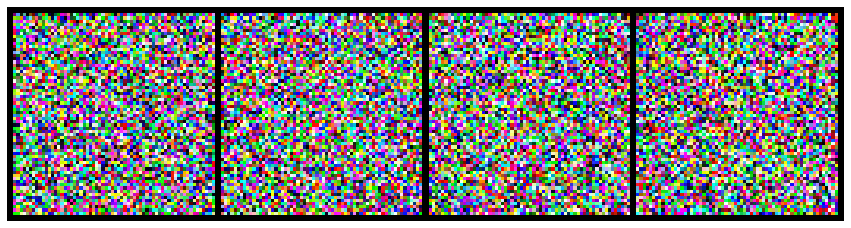

In [ ]:
# Evaluation (sampling) cell

n_steps = 1000
n_samples = 4
image_size = 64
batch_size = 64
load = False
#th.cuda.empty_cache()

# Create predict dataset of latents
z_dataset = UncondLatentDataset((n_samples, 3, image_size, image_size),)

# Load pretrained wrapper if needed
if load:
    decoder = UNetModel(in_channels = 3, model_channels = 128, out_channels = 3, num_res_blocks = 2,
                      attention_resolutions = [16], channel_mult = [1, 2, 2, 2, 4], use_checkpoint = False,
                      dropout = 0.1, num_heads = 1)
    ema_decoder = copy.deepcopy(decoder)
    decoder.eval()
    ema_decoder.eval()

    online_ddpm = DDPM(decoder, beta_1 = 0.0001, beta_2 = 0.02, T = 1000, var_type = "fixedlarge")
    target_ddpm = DDPM(ema_decoder, beta_1 = 0.0001, beta_2 = 0.02, T = 1000, var_type = "fixedlarge")

    net_wrapper = DiffusionVAE(online_ddpm, target_ddpm,
        conditional = False, #False if ddpm_type == "uncond" else True,
        pred_steps = n_steps)
    optimizer = th.optim.Adam(net_wrapper.online_network.decoder.parameters(), lr = net_wrapper.lr)
    loaded_model = th.load("/content/drive/MyDrive/save.pth")
    net_wrapper.online_network.load_state_dict(loaded_model['model_state_dict'])
    optimizer.load_state_dict(loaded_model['optimizer_state_dict'])
    epoch = loaded_model['epoch']
    loss = loaded_model['loss']
    device = DEVICE
    print("Device count:", th.cuda.device_count())

    loader_kws = {}
    if device.startswith("gpu"):
        loader_kws["persistent_workers"] = True
    test_loader = DataLoader(z_dataset, batch_size, num_workers = 1, pin_memory = True, shuffle = False, drop_last = False, **loader_kws)
    print("Loader size", len(test_loader))
else:
    net_wrapper.online_network.decoder.eval()
    net_wrapper.target_network.decoder.eval()
    net_wrapper.pred_steps = n_steps
    device = DEVICE
    print("Device count:", th.cuda.device_count())

    loader_kws = {}
    if device.startswith("gpu"):
        loader_kws["persistent_workers"] = True
    test_loader = DataLoader(z_dataset, batch_size, num_workers = 1, pin_memory = True, shuffle = False, drop_last = False, **loader_kws)
    print("Loader size", len(test_loader))

net_wrapper.predict(test_loader)
show_image_grid(64, n_samples)